## EDA and data cleaning

## Part 0: First glance at the data 

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
# import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
#from sklearn.externals import joblib
from sklearn.utils import shuffle
from preprocessing_helper import encode_person_id, encode_offer_id, convert_data_type, encode_channel, assign_month_num
import pickle
import os
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figures/"+fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


The portfolio dataset contains 10 promotional strategies. Some strategies have cost for the company. For example, for the offer_0, spend 10 dollors will have 10 rewards. Therefore, the profit = revenue - cost = 10 - 10 = 0. If the customer will 10 dollors without promotion. It is better not to spend out the promotions. So it is important to indentify the effective discount offer with least cost for the company. 
The feature "channels" could be an possible features used in the modelling

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


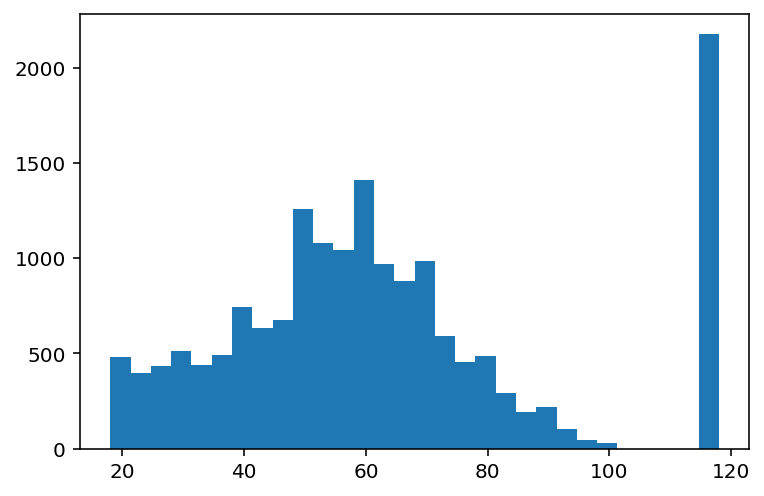

In [6]:
plt.figure()
plt.hist(profile['age'], bins=30)
plt.show()

Few customers has age equal to 118. It might be the default missing value for age.

In [7]:
profile[profile['age'] != 118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


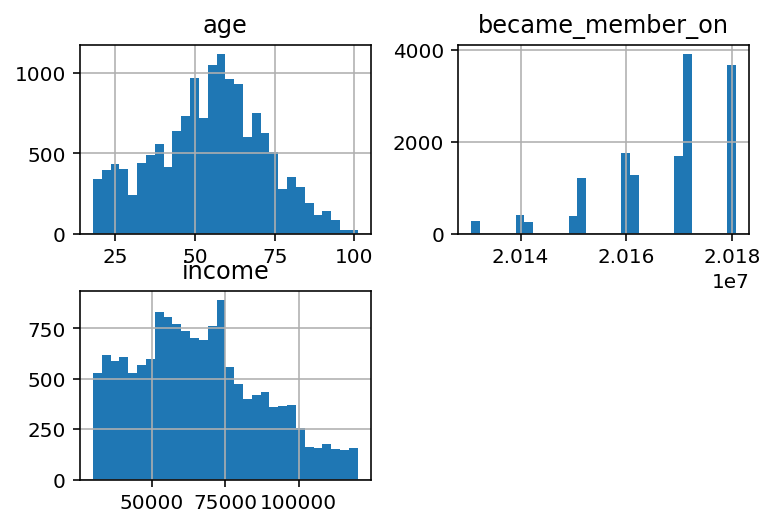

In [8]:
profile[profile['age'] != 118].hist(bins=30)
plt.show()

There are only 4 profile feature. 12.8% data have absurd age information (118 years old) and no gender and became_member_on information. We need to fill the missing value and also create a feature that indicate if it is orignial missing value.

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


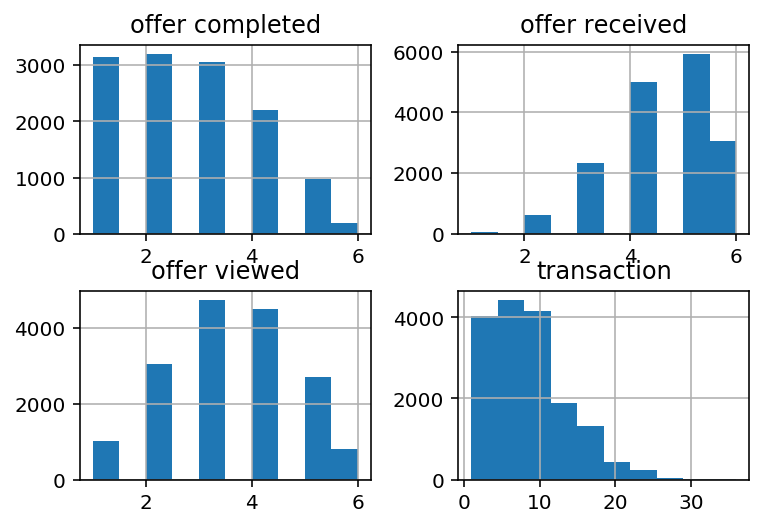

In [10]:
offer_counts = transcript.groupby('person')['event'].value_counts().unstack()
offer_counts.hist()
plt.show()

The figure shows that each customer will recieved 2 to 6 offers and will finish 0 to 20 transactions. 

In [11]:
transcript[transcript['event'] == 'offer received']['value'].apply(lambda x: str(x.values())).value_counts()

dict_values(['9b98b8c7a33c4b65b9aebfe6a799e6d9'])    7677
dict_values(['0b1e1539f2cc45b7b9fa7c272da2e1d7'])    7668
dict_values(['ae264e3637204a6fb9bb56bc8210ddfd'])    7658
dict_values(['2298d6c36e964ae4a3e7e9706d1fb8c2'])    7646
dict_values(['2906b810c7d4411798c6938adc9daaa5'])    7632
dict_values(['5a8bc65990b245e5a138643cd4eb9837'])    7618
dict_values(['3f207df678b143eea3cee63160fa8bed'])    7617
dict_values(['fafdcd668e3743c1bb461111dcafc2a4'])    7597
dict_values(['4d5c57ea9a6940dd891ad53e9dbe8da0'])    7593
dict_values(['f19421c1d4aa40978ebb69ca19b0e20d'])    7571
Name: value, dtype: int64

The promotions are evenly offered 

## Part 1: data preprocessing

Let's me drop the missing value first.

In [12]:
# drop the missing value in profile 
profile = profile[profile['age'] != 118]
# only use the transcript data which have profile data
transcript = transcript[transcript['person'].isin(profile.id)]

### Clean the profile dataset. 
The main task is to encode the id as a readable person id

In [13]:
# convert person_id into integer class from class 0 to class n
person_id_encoder = LabelEncoder()
profile['per_id'] = person_id_encoder.fit_transform(profile['id'])
profile.drop(['id'], axis=1, inplace=True)
# convert became_member_on to datetime
# and extract year, month, day
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['member_year'] = profile['became_member_on'].dt.year
profile['member_month'] = profile['became_member_on'].dt.month
profile['member_day'] = profile['became_member_on'].dt.day
profile.drop(['became_member_on'], axis=1, inplace=True)


# ensure data types are consistent

# ensure age, per_id is int
# ensure gender is string
# ensure income is float
int_var_list = ['age', 'per_id']
float_var_list = ['income']
str_var_list = ['gender']
profile = convert_data_type(profile, int_var_list, float_var_list, str_var_list)
profile.head()
profile.to_pickle("./profile.pkl")

### Clean the portfolio

In [14]:
# encode the offer id 
offer_encoder = LabelEncoder()
portfolio['offer_id'] = offer_encoder.fit_transform(portfolio['id'])
portfolio.drop(['id'], axis=1, inplace=True)
# one-hot encode channels in portfolio
portfolio = encode_channel(portfolio)
portfolio.to_pickle("./portfolio.pkl")
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,7,1,1,1,0
1,10,10,5,bogo,4,1,1,1,1
2,0,0,4,informational,3,1,1,0,1
3,5,5,7,bogo,6,1,1,0,1
4,5,20,10,discount,0,1,0,0,1
5,3,7,7,discount,1,1,1,1,1
6,2,10,10,discount,9,1,1,1,1
7,0,0,3,informational,5,1,1,1,0
8,5,5,5,bogo,8,1,1,1,1
9,2,10,7,discount,2,1,1,0,1


###  Clean the transcript dataset. 

1. Split the transcript into two tables:
   * 'all_offers' : record the data of offers recieved, viewed and completed by users
   * 'transactions: record all the transactions.

2. convert two table into monthly dataset and merge them. Then calculate the monthly profit.

3. create a table to see whether the customer spent more than usual when recieved a promotional offer

In [15]:
# encode the person id
transcript['per_id'] = person_id_encoder.transform(transcript['person'])

# determine whether row deals with offer or transcation
transcript['value_type'] = transcript['value'].apply(lambda x : list(x.keys())[0])
# extract offer id if its an id, or transcation amount if it is a transcation
transcript['value_id_amt'] = transcript['value'].apply(lambda x : list(x.values())[0])
# ensure time and per_id are int
# ensure event and value_type are strings
int_var_list = ['time', 'per_id']
str_var_list = ['event', 'value_type']
transcript = convert_data_type(transcript, int_var_list=int_var_list, str_var_list=str_var_list)

# get transcript for offers only
transcript_offer = transcript[(transcript['event'] !='transaction')][['per_id','event','time','value_type','value_id_amt']]
# encode the offer id
transcript_offer['offer_id'] = offer_encoder.transform(transcript_offer['value_id_amt'])
transcript_offer.drop(['value_type', 'value_id_amt'], axis=1, inplace=True)
transcript_offer.head()

,per_id,event,time,offer_id
0,6962,offer received,0,6
2,13107,offer received,0,2
5,3246,offer received,0,8
7,2669,offer received,0,3
8,9940,offer received,0,0


In [16]:
# merge transcript_offer with portfolio
transcript_offer = pd.merge(transcript_offer, portfolio, how='left', on='offer_id')
transcript_offer.drop(['social','mobile','web','email'], axis=1, inplace=True)
transcript_offer.head()

,per_id,event,time,offer_id,reward,difficulty,duration,offer_type
0,6962,offer received,0,6,5,5,7,bogo
1,13107,offer received,0,2,2,10,7,discount
2,3246,offer received,0,8,5,5,5,bogo
3,2669,offer received,0,3,0,0,4,informational
4,9940,offer received,0,0,5,20,10,discount


In [17]:
transcript_offer[transcript_offer['event']=='offer received'].groupby('offer_id')['per_id'].count()

offer_id
0    6726
1    6655
2    6631
3    6657
4    6593
5    6643
6    6685
7    6683
8    6576
9    6652
Name: per_id, dtype: int64

In [18]:
# get transcript for transactions only
transcript_trans = transcript[transcript['value_type']=='amount'][['per_id','time','value_id_amt']]
transcript_trans.rename(index=str, columns={"time":"time_spent", "value_id_amt":"amt_spent"}, inplace=True)
transcript_trans.head()

,per_id,time_spent,amt_spent
12654,148,0,0.83
12657,9326,0,34.56
12659,4920,0,13.23
12670,10445,0,19.51
12671,14742,0,18.97


In [19]:
# split event {'offer received', 'offer viewed', 'offer completed'} into three features
# and then concatenate them into one row

# generate dataframe tracking when offers received
transcript_offer_received = transcript_offer[transcript_offer['event']=='offer received'][:]
transcript_offer_received.rename(index=str, columns={"time":"time_received"}, inplace=True)
transcript_offer_received.drop(['event'], axis=1, inplace=True)

# generate dataframe tracking when offers viewed
transcript_offer_viewed = transcript_offer[transcript_offer['event']=='offer viewed'][:]
transcript_offer_viewed.rename(index=str, columns={"time":"time_viewed"}, inplace=True)
cols_to_drop = ['event', 'difficulty', 'duration', 'offer_type', 'reward']
transcript_offer_viewed.drop(cols_to_drop, axis=1, inplace=True)

# generate dataframe tracking when offers completed
transcript_offer_completed = transcript_offer[transcript_offer['event']=='offer completed'][:]
transcript_offer_completed.rename(index=str, columns={"time":"time_completed"}, inplace=True)
transcript_offer_completed.drop(cols_to_drop, axis=1, inplace=True)

# merge all 3 together
all_offers = pd.merge(transcript_offer_received, transcript_offer_viewed, on=['per_id', 'offer_id'], how='left')
all_offers = pd.merge(all_offers, transcript_offer_completed, on=['per_id', 'offer_id'], how='left')
all_offers.head()

,per_id,time_received,offer_id,reward,difficulty,duration,offer_type,time_viewed,time_completed
0,6962,0,6,5,5,7,bogo,6.0,132.0
1,13107,0,2,2,10,7,discount,18.0,NaN
2,3246,0,8,5,5,5,bogo,0.0,60.0
3,3246,0,8,5,5,5,bogo,0.0,600.0
4,3246,0,8,5,5,5,bogo,504.0,60.0


At this stage, a lot of offers generated through the merging process are false offers. We will try to eliminate these offers.

We will now keep keep only offers that meet the following conditions:

1. (time offer viewed > time offer received) and (time offer completed > time offer viewed)
2. (time offer viewed > time offer received) and (time completed is null)
3. both time offer viewed and time offer completed are null

Offers that do not meet these conditions are false offers and will be discarded.

In [20]:
# add time of offer expiry column. This will track when offers expires
all_offers['time_expiry'] = all_offers['time_received'] + all_offers['duration']

                        # offers that are viewed and completed after they are received 
all_offers = all_offers[((all_offers['time_viewed'] >= all_offers['time_received']) &\
                        (all_offers['time_completed'] >= all_offers['time_viewed']))
                        |
                        # offers that are viewed after they are received but not completed
                        ((all_offers['time_viewed'] >= all_offers['time_received']) &\
                        all_offers['time_completed'].isnull())
                        |
                        # offers that are received but not viewed or completed
                        (all_offers['time_viewed'].isnull() &\
                         all_offers['time_completed'].isnull())
                       ]


all_offers.head(10)

,per_id,time_received,offer_id,reward,difficulty,duration,offer_type,time_viewed,time_completed,time_expiry
0,6962,0,6,5,5,7,bogo,6.0,132.0,7
1,13107,0,2,2,10,7,discount,18.0,NaN,7
2,3246,0,8,5,5,5,bogo,0.0,60.0,5
3,3246,0,8,5,5,5,bogo,0.0,600.0,5
5,3246,0,8,5,5,5,bogo,504.0,600.0,5
6,2669,0,3,0,0,4,informational,NaN,NaN,4
7,9940,0,0,5,20,10,discount,18.0,NaN,10
8,2860,0,0,5,20,10,discount,150.0,NaN,10
9,4366,0,7,10,10,7,bogo,102.0,510.0,7
10,4366,0,7,10,10,7,bogo,510.0,510.0,7


Now, we will attempt to classify the offers to their probable outcomes.

Offers that are probably successful will be offers that are viewed sometime after they are received but before the offer is completed. This means that the customer is aware of an offer and is making transactions as a result of the offer. In addition, the offer must be completed before it expires. Likewise the time of vewing must also come before the time of completion.

Offers that are probably tried are offers that are either
1. received, viewed but completed after time of expiration
or 
2. received, viewed before the offer expires but the offer is not completed.

Offers that have failed or are false offers will be offers that do not belong to any of the above two classes.

Right now, the classifications are just probable. We will use the transactions data to re-affirm these classifications. We will check if there are any transactions that occur during these offers.

In [21]:
def probable_successful_offers(df):
    if ((df['time_received'] <= df['time_viewed']) &\
        (df['time_viewed'] <= df['time_completed']) &\
        (df['time_completed'] <= df['time_expiry'])):
        return 1
    else:
        return 0
    
def probable_tried_offers(df):
    if (((df['time_received'] <= df['time_viewed']) &\
         (df['time_viewed'] <= df['time_expiry']) &\
         (df['time_expiry'] < df['time_completed']))
        |\
        ((df['time_received'] <= df['time_viewed']) &\
         (df['time_viewed'] <= df['time_expiry']) &\
         (math.isnan(df['time_completed'])))):
        return 1
    else:
        return 0
    
def probable_failed_offers(df):
    if ((df['successful_offer'] == 1) | (df['tried_offer'] == 1)):
        return 0
    else:
        return 1

all_offers['successful_offer'] = all_offers.apply(probable_successful_offers, axis=1)
all_offers['tried_offer'] = all_offers.apply(probable_tried_offers, axis=1)
all_offers['failed_offer'] = all_offers.apply(probable_failed_offers, axis=1)

Drop all duplicated entries including those with duplicated time of receival, person id and offer id. No indivduals received the same offer twice during the same day.

These duplicated entries are eraneous entries generated from the merging process.

In [22]:
all_offers[all_offers.duplicated(subset=['time_received', 'per_id', 'offer_id'])][['per_id', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_expiry', 'successful_offer', 'tried_offer', 'failed_offer']].head()

,per_id,offer_id,time_received,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer
3,3246,8,0,0.0,600.0,5,0,1,0
5,3246,8,0,504.0,600.0,5,0,0,1
10,4366,7,0,510.0,510.0,7,0,0,1
12,11315,3,0,348.0,NaN,4,0,0,1
14,12359,0,0,30.0,624.0,10,0,0,1


In [23]:
# drop all rows with duplicated per_id, offer_id and time_received
# very likely they are double counting
all_offers.drop_duplicates(subset=['time_received', 'per_id', 'offer_id'], keep='first', inplace=True)

print(all_offers.shape)
print(transcript_offer_received.shape)

(55747, 13)
(66501, 7)


Convert the all offers into monthly dataset

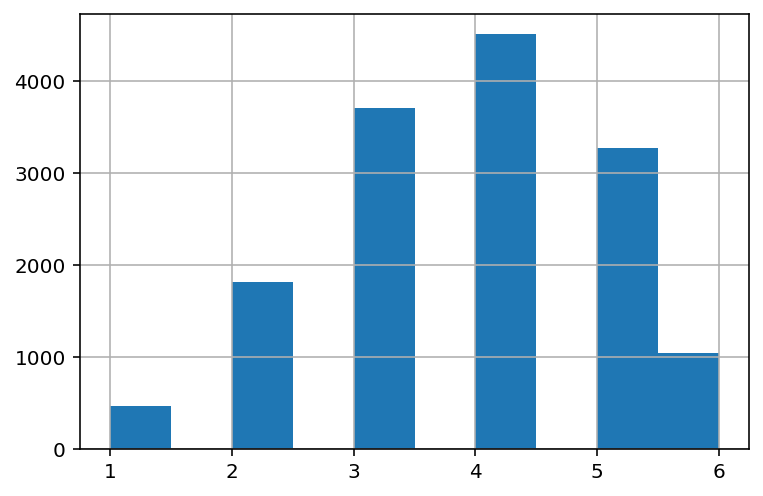

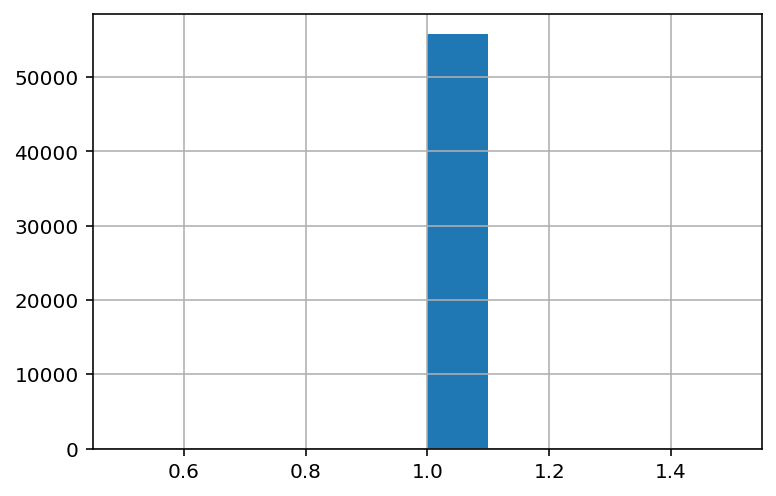

In [24]:
all_offers_month = assign_month_num(all_offers, 'time_received')
all_offers_month.groupby('per_id')['offer_id'].count().hist()
plt.show()
all_offers_month.groupby(['per_id','month_num'])['offer_id'].count().hist()
plt.show()

The customer recieved at most 6 offers. For each person one at most recieved one offer within 1 month.

In [25]:
# check the person_id 14824
all_offers[all_offers_month['per_id'] == 14824]

,per_id,time_received,offer_id,reward,difficulty,duration,offer_type,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,month_num,month_name
1933,14824,0,9,2,10,10,discount,6.0,60.0,10,0,1,0,0,0_29
18923,14824,168,0,5,20,10,discount,174.0,198.0,178,0,1,0,5,150_179
36084,14824,336,2,2,10,7,discount,354.0,384.0,343,0,0,1,11,330_359
53279,14824,408,2,2,10,7,discount,414.0,414.0,415,1,0,0,13,390_419


Saving figure proportion_offer


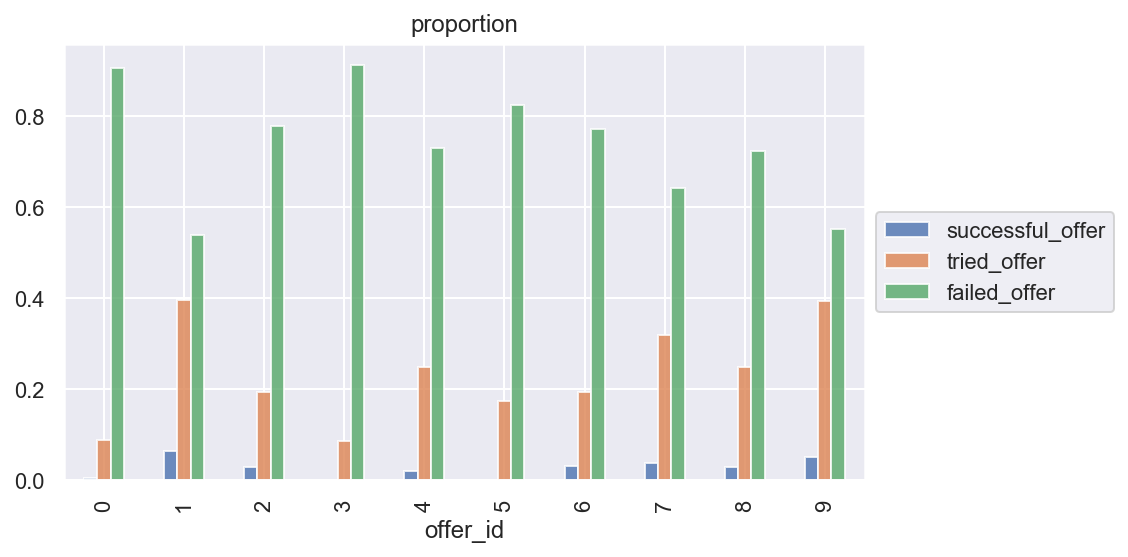

,successful_offer
offer_id,
0,0.005557
1,0.064593
2,0.028442
3,0.000000
4,0.020819
5,0.000000
6,0.032316
7,0.037702
8,0.028566


In [49]:
sns.set()
all_offers.groupby('offer_id')[['successful_offer','tried_offer', 'failed_offer']].mean().plot.bar(figsize=[8,4], alpha=0.8)
plt.title('proportion')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_fig('proportion_offer')
plt.show()
all_offers.groupby('offer_id')[['successful_offer']].mean()


It is interesting to see that most of the offers didn't be completed.  Note offer 3, 5 is informational offer which cannot be completed.

In [27]:
# get transcript for transactions only
transcript_trans = transcript[transcript['value_type']=='amount'][['per_id','time','value_id_amt']]
transcript_trans.rename(index=str, columns={"time":"time_spent", "value_id_amt":"amt_spent"}, inplace=True)
transcript_trans.head()

,per_id,time_spent,amt_spent
12654,148,0,0.83
12657,9326,0,34.56
12659,4920,0,13.23
12670,10445,0,19.51
12671,14742,0,18.97


In [28]:
transaction_month = assign_month_num(transcript_trans, 'time_spent')
transaction_month = transaction_month.groupby(['per_id', 'month_num']).agg({'amt_spent':'sum', 'time_spent':'count'}).reset_index()
transaction_month.rename(columns={'time_spent':'num_transactions'}, inplace=True)
transaction_month.to_pickle("./transaction_month.pkl")

In [29]:
transaction_month.head()

,per_id,month_num,amt_spent,num_transactions
0,0,7,22.16,1
1,0,13,8.57,1
2,0,17,14.11,1
3,0,18,13.56,1
4,0,19,10.27,1


Merge the all_offers month and transactions table and assign the offer id 10 if there is no offer or the offer is failed. If the customer didn't view the offer, then we can assume it didn't affect customers behavior. 

In [30]:
# merge the all_offers_months and transactions
transactions = pd.merge(transaction_month, all_offers_month, on=['per_id', 'month_num'], how='outer')
# assign offer id with 10 if there is no offer 
transactions['offer_id'].fillna(10, inplace=True)
# # assigned the failed offer which didn't viewed by the users before the expired date to offer id
# transactions.loc[transactions['failed_offer'] == 1, 'offer_id'] = 10
transactions['failed_offer'].fillna(0, inplace=True)

In [31]:
transactions.groupby('offer_id')['per_id'].count()

offer_id
0.0      4499
1.0      5883
2.0      4641
3.0      6471
4.0      5956
5.0      6531
6.0      4425
7.0      5570
8.0      5776
9.0      5995
10.0    86603
Name: per_id, dtype: int64

In [32]:
# check per_id == 14824
transactions[transactions['per_id'] == 14824]

,per_id,month_num,amt_spent,num_transactions,time_received,offer_id,reward,difficulty,duration,offer_type,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,month_name
101758,14824,2,23.24,2.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101759,14824,4,9.12,1.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101760,14824,6,38.11,2.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101761,14824,7,18.08,1.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101762,14824,8,23.32,1.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101763,14824,10,16.86,1.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101764,14824,12,15.57,1.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101765,14824,13,17.55,1.0,408.0,2.0,2.0,10.0,7.0,discount,414.0,414.0,415.0,1.0,0.0,0.0,390_419
101766,14824,16,20.96,2.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
101767,14824,19,14.23,1.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


Note there are month that have no transactions and no offer which didn't show in the table. We need to also consider them when calculates the normal spending. 

Now calculate the monthly profit. If the customer successfully complete the offer, we need to deduct the reward when calculate the profit.

In [33]:
transactions['amt_spent'].fillna(0, inplace=True)
transactions['reward'].fillna(0, inplace=True)
transactions['profit'] = transactions['amt_spent']
transactions.loc[transactions['successful_offer'] == 1, 'profit'] -= transactions.loc[transactions['successful_offer'] == 1, 'reward']

In [34]:
transactions.head()

,per_id,month_num,amt_spent,num_transactions,time_received,offer_id,reward,difficulty,duration,offer_type,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,month_name,profit
0,0,7,22.16,1.0,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,22.16
1,0,13,8.57,1.0,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,8.57
2,0,17,14.11,1.0,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,14.11
3,0,18,13.56,1.0,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,13.56
4,0,19,10.27,1.0,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,10.27


Calculate the normal monthly spending by each customer and determine if the customer spent more when recieved the promotional offer 

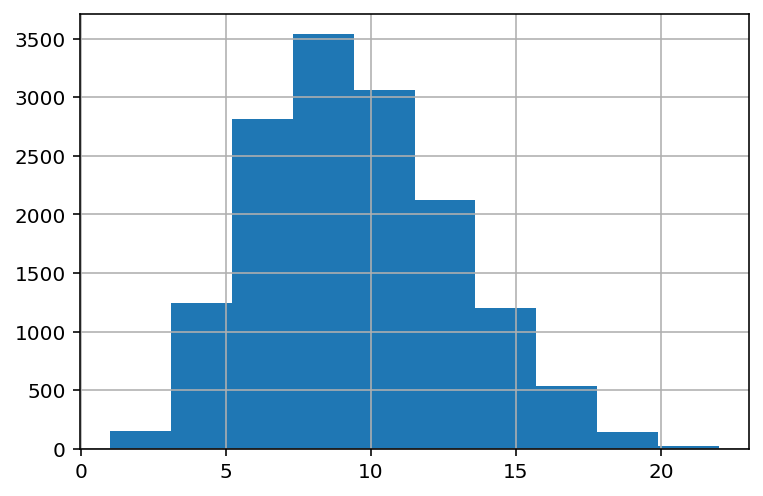

In [35]:
# plot the numbers of month which have data
transactions.groupby('per_id')['month_num'].count().hist()
plt.show()

Note that the datasets have 23 month, however, most customers only have transactions data in 5-15 month.

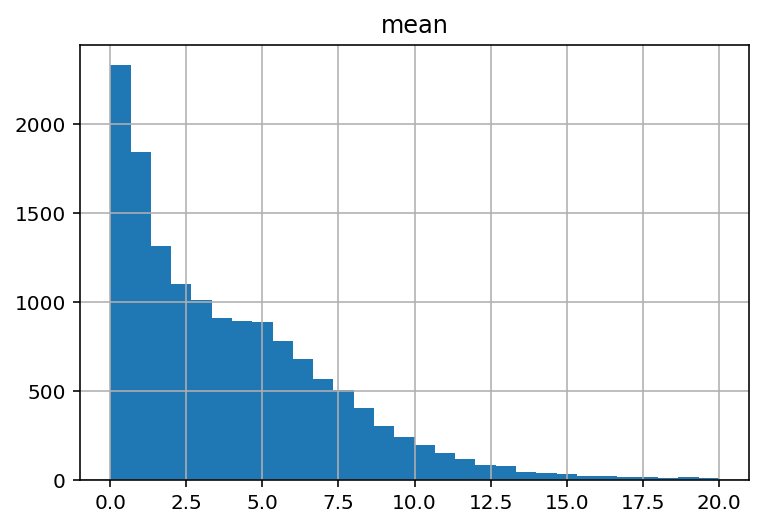

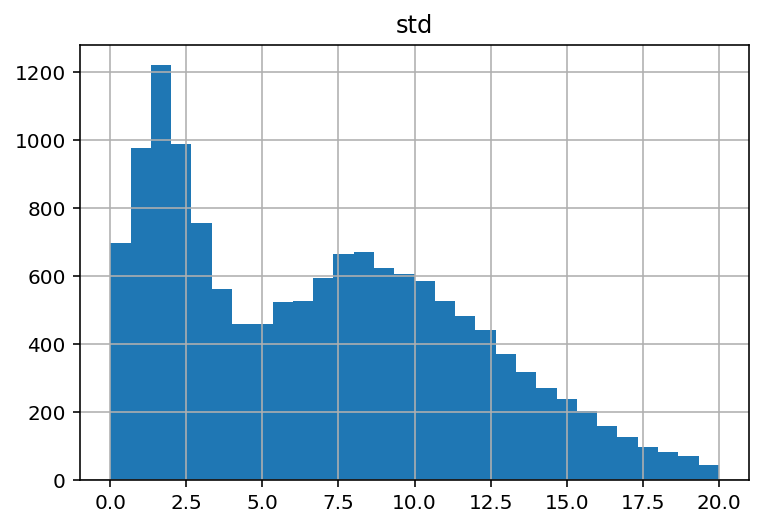

In [36]:
# create the table of normal spending for each person
def calculate_mean_and_std(spending):
    """
    calculate the mean and standard deviation of the list
    """
    n = transactions.month_num.max()
    # fill 0 for the missing month
    tmp = [0]*n
    m = len(spending)
    tmp[:m] = spending
    return np.mean(tmp), np.std(tmp)
    
def calculate_normal_spending(transactions):
    """
    create a dataframe to store the mean and standard deviation of each person's spending 
    when not receiving any offers.
    """
    normal_spending = {'person_id':[], 'mean':[], 'std':[]}
    for person_id in transactions['per_id'].unique():
        mean, std = calculate_mean_and_std(transactions.loc[(transactions['per_id']==person_id) &
                                                            (transactions['offer_id']==10),'amt_spent'])
        normal_spending['person_id'].append(person_id)
        normal_spending['mean'].append(mean)
        normal_spending['std'].append(std)
    return normal_spending

# main
normal_spending = pd.DataFrame(calculate_normal_spending(transactions))

# plot the mean and std of spending
normal_spending['mean'].hist(bins=30, range=(0, 20))
plt.title('mean')
plt.show()
normal_spending['std'].hist(bins=30, range=(0, 20))
plt.title('std')
plt.show()

In [37]:
# assert the calculation of mean is correct
assert (normal_spending[normal_spending['person_id'] == 14824]['mean'].values 
       == sum(transactions.loc[(transactions['per_id']==14824)&(transactions['offer_id']==10), 'amt_spent'])/transactions.month_num.max())

Conduct the statistical hypothesis testing to determine if the customer spent more with the promotional offer than usual on the monthly basis.

Here I assume the monthly spending x is normal distributed. u presents the monthly spending with the offer.
The null hypothesis: u = x
The alternate hypothsis: u > x

I choose the significant level is 0.05
So if u > x+1.645*std(x), I will reject the null hypothsis and determine u > x.

In [38]:
# merge the spending 
offer_spending = transactions.loc[transactions['offer_id']!= 10, 
                                  ['per_id', 'month_num','offer_id', 'profit', 'failed_offer']]
offer_spending.rename(columns={'per_id':'person_id'}, inplace=True)
offer_spending = pd.merge(offer_spending, normal_spending, on=['person_id'], how='left')

# if the spending > mean of the normal spending
offer_spending['above_mean'] = offer_spending['profit'] > offer_spending['mean']

# indentify the customers who viewed the offer and spent more than the mean 
offer_spending['viewed_and_above_mean'] = 0
offer_spending.loc[(offer_spending['failed_offer'] == 0) & 
                   (offer_spending['above_mean']), 'viewed_and_above_mean'] = 1
offer_spending.to_pickle('offer_spending.pkl')

In [39]:
offer_spending

,person_id,month_num,offer_id,profit,failed_offer,mean,std,above_mean,viewed_and_above_mean
0,4,11,3.0,2.29,1.0,1.743913,2.507999,True,0
1,4,13,9.0,5.94,1.0,1.743913,2.507999,True,0
2,5,11,0.0,4.72,1.0,2.773478,5.165133,True,0
3,8,19,7.0,10.65,0.0,0.422174,1.374855,True,1
4,12,5,9.0,6.86,1.0,2.029130,2.554527,True,0
...,...,...,...,...,...,...,...,...,...
55742,11139,19,0.0,0.00,1.0,3.267826,8.772813,False,0
55743,5964,19,0.0,0.00,1.0,5.146522,7.408420,False,0
55744,14424,19,5.0,0.00,1.0,8.780000,14.580680,False,0
55745,6327,19,1.0,0.00,1.0,0.870870,1.689512,False,0


Saving figure proportion_viewed_above_mean


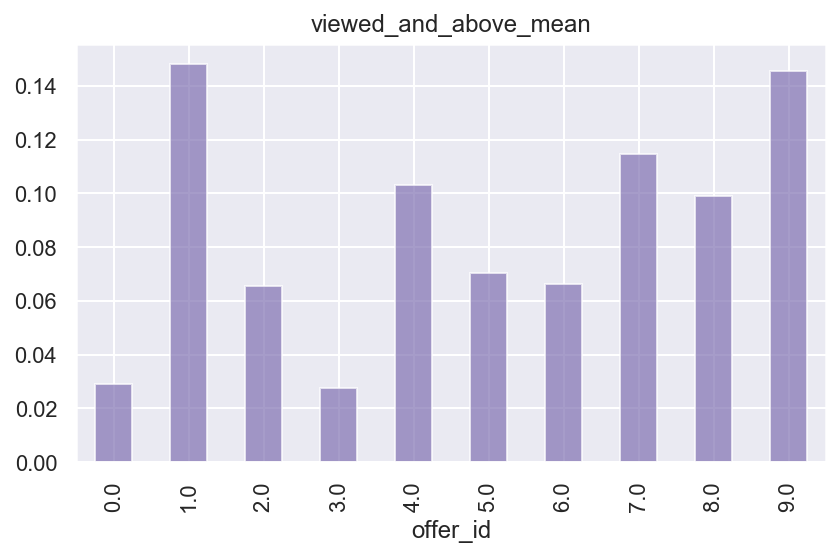

In [40]:
import seaborn as sns
sns.set()
offer_spending.groupby(['offer_id'])['viewed_and_above_mean'].mean().plot.bar(color='m', alpha=0.7)
plt.title('viewed_and_above_mean')
save_fig('proportion_viewed_above_mean')
plt.show()
